In [274]:
import random
import pandas as pd
import numpy as np
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.models import resnet18
from torchvision import transforms

from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore') 
import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


In [275]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [306]:
CFG = {
    'IMG_HEIGHT_SIZE':64,
    'IMG_WIDTH_SIZE':224,
    'EPOCHS':30,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':256,
    'NUM_WORKERS':4, # 본인의 GPU, CPU 환경에 맞게 설정
    'SEED':41
}

In [307]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [308]:
os.getcwd()

'/home/gsc/dacon_KYOWON/Dacon_KYOWON'

In [309]:
#window
# base_dir = 'D:/Dacon_KYOWON/Dacon_KYOWON'
# data_dir = "D:/Dacon_KYOWON/open"
#ubuntu
base_dir = '/home/gsc/dacon_KYOWON/Dacon_KYOWON'
data_dir = '/home/gsc/dacon_KYOWON/open'


In [310]:
#df = pd.read_csv(f'{data_dir}/train.csv')
df = pd.read_csv('train_cutmix.csv')

In [311]:
# 제공된 학습데이터 중 1글자 샘플들의 단어사전이 학습/테스트 데이터의 모든 글자를 담고 있으므로 학습 데이터로 우선 배치
df['len'] = df['label'].str.len()
train_v1 = df[df['len']==1]

In [312]:
# 제공된 학습데이터 중 2글자 이상의 샘플들에 대해서 단어길이를 고려하여 Train (80%) / Validation (20%) 분할
df = df[df['len']>1]
train_v2, val, _, _ = train_test_split(df, df['len'], test_size=0.2, random_state=CFG['SEED'])

데이터 길이를 1,2,3,4로 나눠보는 것은 어떨까

In [313]:
# 학습 데이터로 우선 배치한 1글자 샘플들과 분할된 2글자 이상의 학습 샘플을 concat하여 최종 학습 데이터로 사용
train = pd.concat([train_v1, train_v2])
print(len(train), len(val))

143707 30001


In [314]:
# 학습 데이터로부터 단어 사전(Vocabulary) 구축
train_gt = [gt for gt in train['label']]
train_gt = "".join(train_gt)
letters = sorted(list(set(list(train_gt))))
print(len(letters))

2349


In [315]:
vocabulary = ["-"] + letters
print(len(vocabulary))
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}
char2idx = {v:k for k,v in idx2char.items()}

2350


In [316]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list,transforms=None, train_mode=True):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        self.train_mode = train_mode
        
    def __len__(self):
        return len(self.img_path_list)
    
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        image = cv2.imread(f"{data_dir}/{img_path.split('/')[-2]}/{img_path.split('/')[-1]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transforms is not None:
            image = self.transforms(image=image)['image']
           
        if self.label_list is not None:
            text = self.label_list[index]
            return image, text
        else:
            return image
  

In [317]:
def resize_transform(height,width, state='train'):
    if state == 'train':
        transform = A.Compose([
                                #A.HorizontalFlip(p=0.2),
                                #A.VerticalFlip(p=0.2),
                                A.Rotate(limit=[-10,10], p=1),
                                #A.RandomRotate90(p=0.2),
                                A.Resize(height,width),
                                #A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                                #A.RandomResizedCrop(height=height, width=width, scale=(0.3, 1.0)),
                                #A.ToGray(),
                                A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                ToTensorV2(),
                                ])
    else:
        transform = A.Compose([
                            A.Resize(height,width),
                            #A.ToGray(),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            #A.RandomResizedCrop(height=CFG['IMG_SIZE'], width=CFG['IMG_SIZE'], scale=(0.3, 1.0)),               
                            ToTensorV2()
                            ])

    return transform

In [318]:
train_transform = resize_transform(CFG['IMG_HEIGHT_SIZE'],CFG['IMG_WIDTH_SIZE'])
test_transform = resize_transform(CFG['IMG_HEIGHT_SIZE'],CFG['IMG_WIDTH_SIZE'],'test')

In [319]:
img_path = train['label'].values
print(img_path)
#print(f"{data_dir}/{img_path.split('/')[-2]}/{img_path.split('/')[-1]}")

['머' '써' '빈' ... '행동하다익' '옳싫어하다' '손수']


In [320]:
train_dataset = CustomDataset(train['img_path'].values, train['label'].values, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=CFG['NUM_WORKERS'])

val_dataset = CustomDataset(val['img_path'].values, val['label'].values,test_transform)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=CFG['NUM_WORKERS'])

In [321]:
image_batch, text_batch = iter(train_loader).next()
print(image_batch.size(), text_batch)

torch.Size([256, 3, 64, 224]) ('팬티적어지다', '글쎄요위협', '동그랗다', '항', '생찾아다니다', '야추가', '버려지다', '되게깸', '빚', '걱정되다긴급', '투표전체', '뺏', '통증옥', '될조심스럽다', '휜', '예의', '그리', '퓌', '메일휴', '역사학수만', '변명', '주무시다새끼', '즐거움죔', '푸르다', '참기름곳곳', '공업', '싸조사하다', '에', '쬡', '안기다총', '생신실현되다', '일본고치다', '참석자', '근거다름없다', '손길', '몽', '운동화', '쫄신랑', '녹화코', '정직하다외침', '쥐참가', '나빠지다성적', '석표시하다', '세기', '보내다확실히', '텍스트', '발소주', '흘러나오다믿', '강요하다', '구분지붕', '꿍', '덤', '젬칼국수', '계산하다퓟', '화분', '깩좌우', '던지다출판', '동화책', '넷째', '수집하다', '입원', '불법', '건전하다년생', '몹시위', '창조하다숟', '자율머물다', '밤새다퓜', '시각주저앉다', '검다', '통과하다', '서부', '손님', '금지되다', '홈페이지요금', '있다감상', '술병', '경영하다녕', '눋', '등록하다깜짝', '며', '뗏할아버지', '앙', '쿤끊어지다', '점차다섯째', '유명하다위', '곡', '쉬다내', '주장하다', '평가되다', '가능해지다', '수', '선자연스럽다', '췻비교하다', '첫유의하다', '양식', '빛', '뵤중요', '들이마시다', '포함접시', '상당수음주', '불법츳', '릉결석하다', '형수', '나가다', '관련', '졌갈증', '재능', '들어오다', '오피스텔았', '어쩐지이리', '정', '깻', '회복되다', '늙', '구분되다청년', '그럼애초', '자차이', '수동적현장', '요구하다폣', '편견아가씨', '금액', '뒵양복', '두다예식장', '땠', '도망가다', '실례의미하다', '밝다경향', '채우다', '신체

In [322]:
from torchsummary import summary as summary_

In [323]:
# resnet_test = resnet18(pretrained=True)
# resnet_test.cuda()
# summary_(resnet_test,(3,64,224))

In [324]:
import torchvision.models as models
eff_test = models.efficientnet_b5(pretrained=True)
eff_test.cuda()
summary_(eff_test,(3,64,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 48, 32, 112]           1,296
       BatchNorm2d-2          [-1, 48, 32, 112]              96
              SiLU-3          [-1, 48, 32, 112]               0
            Conv2d-4          [-1, 48, 32, 112]             432
       BatchNorm2d-5          [-1, 48, 32, 112]              96
              SiLU-6          [-1, 48, 32, 112]               0
 AdaptiveAvgPool2d-7             [-1, 48, 1, 1]               0
            Conv2d-8             [-1, 12, 1, 1]             588
              SiLU-9             [-1, 12, 1, 1]               0
           Conv2d-10             [-1, 48, 1, 1]             624
          Sigmoid-11             [-1, 48, 1, 1]               0
SqueezeExcitation-12          [-1, 48, 32, 112]               0
           Conv2d-13          [-1, 24, 32, 112]           1,152
      BatchNorm2d-14          [-1, 24, 

In [325]:
class RecognitionModel_eff(nn.Module):
    def __init__(self, num_chars=len(char2idx), rnn_hidden_size=256):
        super(RecognitionModel_eff, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        
        # CNN Backbone = 사전학습된 resnet18 활용
        # https://arxiv.org/abs/1512.03385
        effnet = models.efficientnet_b5(pretrained=True)
        # CNN Feature Extract
        effnet_modules = list(effnet.features)[:-3]
        self.feature_extract = nn.Sequential(
            *effnet_modules,
            nn.Conv2d(176, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.linear1 = nn.Linear(1024, rnn_hidden_size)
        
        # RNN
        self.rnn = nn.RNN(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        #LSTM
        self.lstm = nn.LSTM(input_size=rnn_hidden_size,
                           hidden_size= rnn_hidden_size,
                           bidirectional = True,
                           batch_first=True)
        
        #GRU
        self.gru = nn.GRU(input_size=rnn_hidden_size,
                           hidden_size= rnn_hidden_size,
                           bidirectional = True,
                           batch_first=True)
        
    def forward(self, x):
        # CNN
        x = self.feature_extract(x) # [batch_size, channels, height, width]
        x = x.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
         
        batch_size = x.size(0)
        T = x.size(1)
        x = x.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        x = self.linear1(x)
        #print(x.shape)
        # RNN
        #x, hidden = self.rnn(x)
        
        #LSTM
        x, (hidden,_) = self.lstm(x)
        #GRU
        #x, (hidden,_) = self.gru(x)
        
        output = self.linear2(x)
        output = output.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        
        return output

In [326]:
RecognitionModel_eff_test = RecognitionModel_eff()
RecognitionModel_eff_test.cuda()
#summary_(RecognitionModel_eff_test,(3,64,224))
#RecognitionModel_eff_test.state_dict().keys()

RecognitionModel_eff(
  (feature_extract): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2)

In [327]:
# RecognitionModel_test = RecognitionModel()
# RecognitionModel_test.cuda()
# summary_(RecognitionModel_test,(3,64,224))

In [328]:
# class RecognitionModel(nn.Module):
#     def __init__(self, num_chars=len(char2idx), rnn_hidden_size=256):
#         super(RecognitionModel, self).__init__()
#         self.num_chars = num_chars
#         self.rnn_hidden_size = rnn_hidden_size
        
#         # CNN Backbone = 사전학습된 resnet18 활용
#         # https://arxiv.org/abs/1512.03385
#         resnet = resnet18(pretrained=True)
#         # CNN Feature Extract
#         resnet_modules = list(resnet.children())[:-3]
#         self.feature_extract = nn.Sequential(
#             *resnet_modules,
#             nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True)
#         )

#         self.linear1 = nn.Linear(1024, rnn_hidden_size)
        
#         # RNN
#         self.rnn = nn.RNN(input_size=rnn_hidden_size, 
#                             hidden_size=rnn_hidden_size,
#                             bidirectional=True, 
#                             batch_first=True)
#         self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
#     def forward(self, x):
#         # CNN
#         x = self.feature_extract(x) # [batch_size, channels, height, width]
#         x = x.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
         
#         batch_size = x.size(0)
#         T = x.size(1)
#         x = x.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
#         x = self.linear1(x)
        
#         # RNN
#         x, hidden = self.rnn(x)
        
#         output = self.linear2(x)
#         output = output.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        
#         return output

In [329]:
criterion = nn.CTCLoss(blank=0) # idx 0 : '-'

In [330]:
def encode_text_batch(text_batch):
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [331]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 

    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [332]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    
    best_loss = 999999
    best_model = None
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for image_batch, text_batch in tqdm(iter(train_loader)):
            image_batch = image_batch.to(device)
            
            optimizer.zero_grad()
            
            text_batch_logits = model(image_batch)
            loss = compute_loss(text_batch, text_batch_logits)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        _train_loss = np.mean(train_loss)
        
        _val_loss = validation(model, val_loader, device)
        print(f'Epoch : [{epoch}] Train CTC Loss : [{_train_loss:.5f}] Val CTC Loss : [{_val_loss:.5f}]')
        
        if scheduler is not None:
            scheduler.step(_val_loss)
        
        if best_loss > _val_loss:
            best_loss = _val_loss
            best_model = model
    
    return best_model

In [333]:
def validation(model, val_loader, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for image_batch, text_batch in tqdm(iter(val_loader)):
            image_batch = image_batch.to(device)
            
            text_batch_logits = model(image_batch)
            loss = compute_loss(text_batch, text_batch_logits)
            
            val_loss.append(loss.item())
    
    _val_loss = np.mean(val_loss)
    return _val_loss

In [334]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [335]:
model = RecognitionModel_eff()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [1] Train CTC Loss : [5.67722] Val CTC Loss : [3.97212]


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [2] Train CTC Loss : [3.00999] Val CTC Loss : [1.98762]


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [3] Train CTC Loss : [1.77758] Val CTC Loss : [1.56715]


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [4] Train CTC Loss : [1.40045] Val CTC Loss : [1.43715]


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [5] Train CTC Loss : [1.23214] Val CTC Loss : [1.36885]


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [6] Train CTC Loss : [1.14140] Val CTC Loss : [1.34958]


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [7] Train CTC Loss : [1.08408] Val CTC Loss : [1.34210]


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [8] Train CTC Loss : [1.05149] Val CTC Loss : [1.33329]


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [9] Train CTC Loss : [1.02145] Val CTC Loss : [1.37366]


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [10] Train CTC Loss : [1.00117] Val CTC Loss : [1.33211]


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [11] Train CTC Loss : [0.97456] Val CTC Loss : [1.32656]


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [12] Train CTC Loss : [0.95191] Val CTC Loss : [1.33998]


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [13] Train CTC Loss : [0.93331] Val CTC Loss : [1.34193]


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [14] Train CTC Loss : [0.91622] Val CTC Loss : [1.34313]
Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [15] Train CTC Loss : [0.84241] Val CTC Loss : [1.32987]


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [16] Train CTC Loss : [0.81770] Val CTC Loss : [1.32200]


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [17] Train CTC Loss : [0.80247] Val CTC Loss : [1.33684]


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [18] Train CTC Loss : [0.79018] Val CTC Loss : [1.34511]


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [19] Train CTC Loss : [0.77698] Val CTC Loss : [1.37434]
Epoch 00019: reducing learning rate of group 0 to 2.5000e-04.


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [20] Train CTC Loss : [0.73368] Val CTC Loss : [1.37912]


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [21] Train CTC Loss : [0.71610] Val CTC Loss : [1.39948]


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [22] Train CTC Loss : [0.70371] Val CTC Loss : [1.40574]
Epoch 00022: reducing learning rate of group 0 to 1.2500e-04.


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [23] Train CTC Loss : [0.67588] Val CTC Loss : [1.42399]


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [24] Train CTC Loss : [0.66517] Val CTC Loss : [1.44479]


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [25] Train CTC Loss : [0.65809] Val CTC Loss : [1.45226]
Epoch 00025: reducing learning rate of group 0 to 6.2500e-05.


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [26] Train CTC Loss : [0.64088] Val CTC Loss : [1.46868]


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [27] Train CTC Loss : [0.63497] Val CTC Loss : [1.47642]


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [28] Train CTC Loss : [0.63091] Val CTC Loss : [1.49688]
Epoch 00028: reducing learning rate of group 0 to 3.1250e-05.


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [29] Train CTC Loss : [0.62081] Val CTC Loss : [1.49879]


  0%|          | 0/562 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch : [30] Train CTC Loss : [0.61825] Val CTC Loss : [1.50526]


In [336]:
torch.save(infer_model,'./weight_file/b5_30_lstm_cutmix.pt')

In [337]:
# model = RecognitionModel()
# model.eval()
# optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

# infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

In [338]:
test = pd.read_csv('../open/test.csv')

In [339]:
test_dataset = CustomDataset(test['img_path'].values, None,test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=CFG['NUM_WORKERS'])

In [340]:
def decode_predictions(text_batch_logits):
    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for image_batch in tqdm(iter(test_loader)):
            image_batch = image_batch.to(device)
            
            text_batch_logits = model(image_batch)
            
            text_batch_pred = decode_predictions(text_batch_logits.cpu())
            
            preds.extend(text_batch_pred)
    return preds

In [341]:
predictions = inference(infer_model, test_loader, device)

  0%|          | 0/290 [00:00<?, ?it/s]

In [342]:
# 샘플 별 추론결과를 독립적으로 후처리
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [343]:
submit = pd.read_csv('../open/sample_submission.csv')
submit['label'] = predictions
submit['label'] = submit['label'].apply(correct_prediction)

In [344]:
submit.to_csv('./submission/submission_30_eff_lstm_cutmix.csv', index=False)

In [345]:
sub_text = pd.read_csv('./submission/submission_30_eff_lstm_cutmix.csv')
sub_text

,id,label
0,TEST_00000,남망
1,TEST_00001,상향
2,TEST_00002,받아이다
3,TEST_00003,바구니
4,TEST_00004,살
...,...,...
74116,TEST_74116,캐나다
74117,TEST_74117,사무
74118,TEST_74118,친절하다
74119,TEST_74119,쪽


In [ ]:
# cutmix사용 혹은 ATTENTION 구조 사용

In [182]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import random
import os
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

In [185]:
df = pd.read_csv('../open/train.csv')
df['len'] = df['label'].str.len()

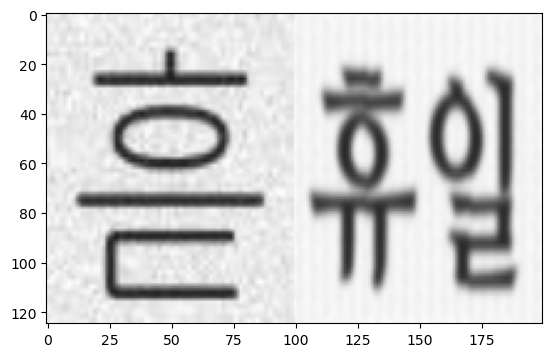

In [189]:
select1, select2 = random.randint(0, 76888), random.randint(0, 76888)
imgFile1 = f'../open/train/TRAIN_{select1:05d}.png'
imgFile2 = f'../open/train/TRAIN_{select2:05d}.png'


# 이미지 읽기
img1 = cv2.imread(imgFile1, 1); #1:color # 0:gray
img2 = cv2.imread(imgFile2, 1);

# 사이즈 조절
img1 = cv2.resize(img1,(100,125))
img2 = cv2.resize(img2,(100,125))

# 이미지 붙이기
addh = cv2.hconcat([img1, img2])
plt.imshow(addh)

In [197]:
os.makedirs("./Cut_mix",exist_ok=True)

In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76888 entries, 0 to 76887
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        76888 non-null  object
 1   img_path  76888 non-null  object
 2   label     76888 non-null  object
 3   len       76888 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [192]:
df_len_count = pd.DataFrame(df['len'].value_counts())
df_len_count.reset_index(inplace=True)
df_len_count.columns = ['len', 'len_count']

display(df_len_count)

,len,len_count
0,2,28631
1,1,23703
2,3,13514
3,4,9988
4,5,1026
5,6,26


In [193]:
len2count = {k:v for k,v in zip(df_len_count['len'], df_len_count['len_count'])}

In [194]:
len2count

{2: 28631, 1: 23703, 3: 13514, 4: 9988, 5: 1026, 6: 26}

In [198]:
idx = 76888 
for i in tqdm(range(200000)):
    select1, select2 = random.randint(0, 76887), random.randint(0, 76887)
    imgFile1 = f'../open/train/TRAIN_{select1:05d}.png'
    imgFile2 = f'../open/train/TRAIN_{select2:05d}.png'
    
    if df['len'][select1] + df['len'][select2] > 6:
        continue
        
    if len2count[df['len'][select1] + df['len'][select2]] > 30000:
        continue
    
    # 이미지 읽기
    img1 = cv2.imread(imgFile1, 1);
    img2 = cv2.imread(imgFile2, 1);
    
    img1 = cv2.resize(img1,(100,125))
    img2 = cv2.resize(img2,(100,125))
    
    addh = cv2.hconcat([img1, img2])
    
    new_data = {
        'id' : f"TRAIN_{idx:06d}",
        'img_path' : f"./Cut_mix/TRAIN_{idx:06d}.png",
        'label' : df['label'][select1] + df['label'][select2],
        'len' : df['len'][select1] + df['len'][select2]
    }
    
    df = df.append(new_data, ignore_index=True)
    cv2.imwrite(f"./Cut_mix/TRAIN_{idx:06d}.png", addh)
    idx += 1
    len2count[df['len'][select1] + df['len'][select2]] += 1

  0%|          | 0/200000 [00:00<?, ?it/s]

In [199]:
df.to_csv('./train_cutmix.csv', index=False)

In [200]:
df

,id,img_path,label,len
0,TRAIN_00000,./train/TRAIN_00000.png,빨간색,3
1,TRAIN_00001,./train/TRAIN_00001.png,머,1
2,TRAIN_00002,./train/TRAIN_00002.png,차차,2
3,TRAIN_00003,./train/TRAIN_00003.png,써,1
4,TRAIN_00004,./train/TRAIN_00004.png,놓치다,3
...,...,...,...,...
173703,TRAIN_155657,./Cut_mix/TRAIN_155657.png,웬만하다지다,6
173704,TRAIN_155658,./Cut_mix/TRAIN_155658.png,깨어나다아픔,6
173705,TRAIN_155659,./Cut_mix/TRAIN_155659.png,나이싫어지다,6
173706,TRAIN_155660,./Cut_mix/TRAIN_155660.png,신문사바치다,6
